In [72]:
# 压线桶污染检测

# 下面两行用不到可以注掉，因为我用的是VS Code，不知道怎么回事找不到模块要自己添加一下
# import sys
# sys.path.append('/Users/zhouxinyu/Code/Coding/zf_back_py')

from code import interact
import cv2
import numpy as np
from numpy import ndarray
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib
import math
import pickle

ColorType = Tuple[int, int ,int]

class BarrelContaminationDetect():

    def __init__(self):
        self.blockSize = 10  # 块大小
        self.distanceThreshold = 20  # 距离阈值
        pkl_file = open('pickle/baseDuck.pkl', 'rb')
        self.baseDuck = pickle.load(pkl_file)  # 存放基准色的数组
        pkl_file.close()
        # 读取baseImages文件夹下的图片，生成基准色数组中的内容
        # baseImgRoot = '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/全量测试数据/base/'
        # baseImgNameList = ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

        # for name in baseImgNameList:
        #     curBaseImg = cv2.imread(
        #         baseImgRoot + name, cv2.IMREAD_COLOR)
        #     self.baseDuck = list(set(self.baseDuck) ^ set(
        #         self.getAvgColorList(curBaseImg)))
        
        # output = open('pickle/baseDuck.pkl', 'wb')
        # pickle.dump(self.baseDuck, output, -1)

    def cutBlack(self, img: ndarray) -> ndarray:
        """
        输入一张图片，切割去掉左侧黑色区域，返回切割后的图片
        """
        gray = np.transpose(
            cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        )
        blackNumbers = 0
        for i in range(0, gray.shape[0]):
            blackNumbers = blackNumbers + 1
            if sum(gray[i] > 0):
                return img[:, blackNumbers: img.shape[1]]

    def getDistance(self, p1: ColorType, p2: ColorType) -> int:
        """
        计算RGB空间里两个点颜色上的距离
        """
        return int(math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2))

    def getAvgColorList(self, img: ndarray) -> List[ColorType]:
        """
        计算RGB空间里两个点颜色上的距离
        """
        row = img.shape[0]
        col = img.shape[1]
        blocks = []  # 存放切片
        blockAvgColorList = []  # 每个区块对应的颜色值
        rowGroupNum = math.ceil(row / self.blockSize)
        colGroupNum = math.ceil(col / self.blockSize)
        for i in range(rowGroupNum):
            for j in range(colGroupNum):
                curBlock = img[
                    i*self.blockSize: (i+1)*self.blockSize,
                    j*self.blockSize: (j+1)*self.blockSize
                ]
                curB, curG, curR = cv2.split(curBlock)
                blockAvgColorList.append((
                    int(np.mean(curB)),
                    int(np.mean(curG)),
                    int(np.mean(curR)),
                ))
                blocks.append(curBlock)
        return blockAvgColorList

    def drawBlock(self, img: ndarray, blocks: List[int]) -> ndarray:
        """
        输入一个图片，和一个数组，在图片上依次标出图片上的绿框，并返回被标记绿框后的图片
        """
        res = img.copy()
        col = img.shape[1]
        # self.blockSize = 50 # 裁剪区块边长度，正方形]
        colGroupNum = math.ceil(col / self.blockSize)
        font_size = 5
        for index in blocks:
            left = self.blockSize * (index % colGroupNum)
            top = self.blockSize * int(index / colGroupNum)
            right = left + self.blockSize
            bottom = top + self.blockSize
            cv2.rectangle(res, (left, top), (right, bottom),
                          (0, 255, 0), font_size, 4)
        return res

    def isKeep(self, o_list: List[ColorType], color: ColorType) -> bool:
        """
        :param o_list: 基准色数组, color：一个颜色
        :return: 第一个返回值是处理后的图片，第二个返回值是统计的疑似污染区域的个数，污染区域大小为[self.blockSize**2]
        """
        if set(o_list).__contains__(color):
            return True
        for o_color in o_list:
            if self.getDistance(o_color, color) < self.distanceThreshold:
                return True
        return False

    def process_image(self, image: ndarray) -> Tuple[ndarray, int]:
        """
        :param image: 读入的图片
        :return: 第一个返回值是处理后的图片，第二个返回值是判断图片是否污染，第三个返回值是统计的疑似污染区域的个数，污染区域大小为[self.blockSize**2]
        """
        image = self.cutBlack(image)
        targetImgBaseColorList = self.getAvgColorList(
            image[:, int(0.25 * image.shape[1]): int(0.5 * image.shape[1])])
        # targetImgBaseColorList_2 = self.getAvgColorList(
        #     image[:, int(0.9 * image.shape[1]): image.shape[1]])
        # targetImgColorList = self.getAvgColorList(image)

        # imgOfTarget = image[:, int(0 * image.shape[1]):int(1 * image.shape[1])]
        imgOfTarget = image[:, int(0 * image.shape[1]):int(0.25 * image.shape[1])]
        
        targetImgColorList = self.getAvgColorList(imgOfTarget)
        # baseColors = list(set(targetImgBaseColorList))
        baseColors = list(set(targetImgBaseColorList) ^ set(self.baseDuck))
        diffColorIndex = []
        for i in range(len(targetImgColorList)):
            if not self.isKeep(baseColors, targetImgColorList[i]):
                diffColorIndex.append(i)
        # return (len(diffColorIndex)>4, len(diffColorIndex))
        return (self.drawBlock(imgOfTarget, diffColorIndex), len(diffColorIndex)>4, len(diffColorIndex))

bcd = BarrelContaminationDetect()

In [3]:
def showImages(images, titles = [''], size = [1, 1], BGR = False):
    for i in range(len(images)):
        plt.subplot(size[0], size[1], i + 1)
        showImage = images[i]
        if (BGR):
            b,g,r = cv2.split(images[i])
            showImage = cv2.merge([r,g,b])
        plt.imshow(showImage ,'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

        
def imwrite(filename, file):
    dir = os.path.join(os.getcwd(), 'data-5-20')
    if not os.path.exists(dir):
        os.makedirs(dir)
    cv2.imwrite(os.path.join(dir, filename), file)


def cv_show(img):
    cv2.imshow('cv_show', img)
    cv2.waitKey(0)  # 等待时间，毫秒级，0标示按任意键终止
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # 解决mac中窗口不关闭的问题



def drawBlock(img, blockSize):
    """
    输入一个图片，和一个数组，在图片上依次标出图片上的绿框，并返回被标记绿框后的图片
    """
    res = img.copy()
    col = img.shape[1]
    # self.blockSize = 50 # 裁剪区块边长度，正方形]
    colGroupNum = math.ceil(col / blockSize)
    font_size = 5
    for index in range(4000):
        left = blockSize * (index % colGroupNum)
        top = blockSize * int(index / colGroupNum)
        right = left + blockSize
        bottom = top + blockSize
        cv2.rectangle(res, (left, top), (right, bottom),
                        (0, 255, 0), font_size, 4)
    return res

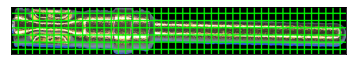

In [20]:
# 使用示例
# targetImg = cv2.imread(
#             '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/maxEdge调整同向/正常/9.png', cv2.IMREAD_COLOR)
# targetImg = cv2.imread(
#             '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/maxEdge调整同向/糊边/3.png', cv2.IMREAD_COLOR)
targetImg = cv2.imread(
            '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/全量测试数据/正常图片/1.png', cv2.IMREAD_COLOR)
# print(isContaminated, suspectedAreaNumber)
blockSize = 40
imgName = '块'+ str(blockSize) +'.png'
imgWithBlock = drawBlock(targetImg ,blockSize)
showImages([imgWithBlock], BGR=True)
imwrite(imgName, imgWithBlock)
# cv_show(drawBlock(targetImg ,50))

True 21


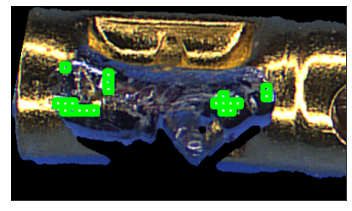

In [75]:
# 使用示例
targetImg = cv2.imread(
            '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/maxEdge调整同向/正常/8.png', cv2.IMREAD_COLOR)
# targetImg = cv2.imread(
#             '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/maxEdge调整同向/糊边/3.png', cv2.IMREAD_COLOR)
# targetImg = cv2.imread(
#             '/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/压线筒污染/全量测试数据/正常图片/4.png', cv2.IMREAD_COLOR)
returnImg, isContaminated, suspectedAreaNumber = bcd.process_image(targetImg)
print(isContaminated, suspectedAreaNumber)
showImages([returnImg], BGR=True);